# FreshHarvest Model Experiments

This notebook contains experiments with different CNN architectures for fruit freshness classification.
We'll compare Basic CNN, Improved CNN with ResNet blocks, and Lightweight CNN architectures.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Import custom modules
from cvProject_FreshHarvest.utils.common import read_yaml, setup_logging
from cvProject_FreshHarvest.models.cnn_models import FreshHarvestCNN

# Setup
setup_logging()
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: []


## 1. Load Configuration and Data

In [2]:
# Load configuration
config = read_yaml('../config/config.yaml')
print("Configuration loaded:")
print(f"- Image size: {config['data']['image_size']}")
print(f"- Number of classes: {config['data']['num_classes']}")
print(f"- Batch size: {config['training']['batch_size']}")
print(f"- Learning rate: {config['training']['learning_rate']}")

Configuration loaded:
- Image size: [224, 224]
- Number of classes: 16
- Batch size: 32
- Learning rate: 0.001


In [3]:
# Create data generators
def create_data_generators(batch_size=32):
    """Create training and validation data generators."""
    
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Validation data generator (no augmentation)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        '../data/processed/train',
        target_size=tuple(config['data']['image_size']),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_directory(
        '../data/processed/val',
        target_size=tuple(config['data']['image_size']),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, val_generator

# Create generators
train_gen, val_gen = create_data_generators()
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Classes: {list(train_gen.class_indices.keys())}")

Found 11199 images belonging to 16 classes.
Found 3200 images belonging to 16 classes.
Training samples: 11199
Validation samples: 3200
Classes: ['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']


## 2. Model Architecture Comparison

In [4]:
# Initialize CNN model builder
cnn_builder = FreshHarvestCNN('../config/config.yaml')

# Create different model architectures
models = {
    'Basic CNN': cnn_builder.create_basic_cnn(),
    'Improved CNN': cnn_builder.create_improved_cnn(),
    'Lightweight CNN': cnn_builder.create_lightweight_cnn()
}

# Display model summaries
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print(f"{'='*50}")
    print(f"Total parameters: {model.count_params():,}")
    print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
    
    # Show model architecture
    model.summary()

2025-06-18 17:51:15,343 - root - INFO - CNN model initialized
2025-06-18 17:51:16,197 - root - INFO - Created basic CNN model with 1444272 parameters
2025-06-18 17:51:17,147 - root - INFO - Created improved CNN model with 11592080 parameters
2025-06-18 17:51:17,457 - root - INFO - Created lightweight CNN model with 83019 parameters

Model: Basic CNN
Total parameters: 1,444,272
Trainable parameters: 1,441,776


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,272 (5.51 MB)

 Trainable params: 1,441,776 (5.50 MB)

 Non-trainable params: 2,496 (9.75 KB)


Model: Improved CNN
Total parameters: 11,592,080
Trainable parameters: 11,580,944


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_12[0][0] 

 Total params: 11,592,080 (44.22 MB)

 Trainable params: 11,580,944 (44.18 MB)

 Non-trainable params: 11,136 (43.50 KB)


Model: Lightweight CNN
Total parameters: 83,019
Trainable parameters: 81,803


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 224, 224, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 112, 112, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 56, 56, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 28, 28, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,019 (324.29 KB)

 Trainable params: 81,803 (319.54 KB)

 Non-trainable params: 1,216 (4.75 KB)

## 3. Model Training Experiments

In [5]:
def train_model_experiment(model, model_name, epochs=10):
    """Train a model and return training history."""
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['training']['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    # Create callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print(f"\nTraining {model_name}...")
    
    # Train model
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1,
        steps_per_epoch=min(50, train_gen.samples // config['training']['batch_size']),
        validation_steps=min(20, val_gen.samples // config['training']['batch_size'])
    )
    
    return history

# Train all models (short training for comparison)
training_histories = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")
    
    try:
        history = train_model_experiment(model, name, epochs=5)
        training_histories[name] = history
        print(f"✅ {name} training completed successfully!")
    except Exception as e:
        print(f"❌ {name} training failed: {e}")
        training_histories[name] = None


Training Basic CNN

Training Basic CNN...
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - accuracy: 0.1099 - loss: 3.6587 - precision: 0.1297 - recall: 0.0396 - val_accuracy: 0.3125 - val_loss: 2.9602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 353s 7s/step - accuracy: 0.1933 - loss: 2.9224 - precision: 0.2826 - recall: 0.0812 - val_accuracy: 0.0000e+00 - val_loss: 4.9047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 426s 9s/step - accuracy: 0.2431 - loss: 2.5631 - precision: 0.3511 - recall: 0.1043 - val_accuracy: 0.0000e+00 - val_loss: 5.5009 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2653 - loss: 2.2959 - precision: 0.4284 - recall: 0.1303
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 480s 10

## 4. Training Results Visualization

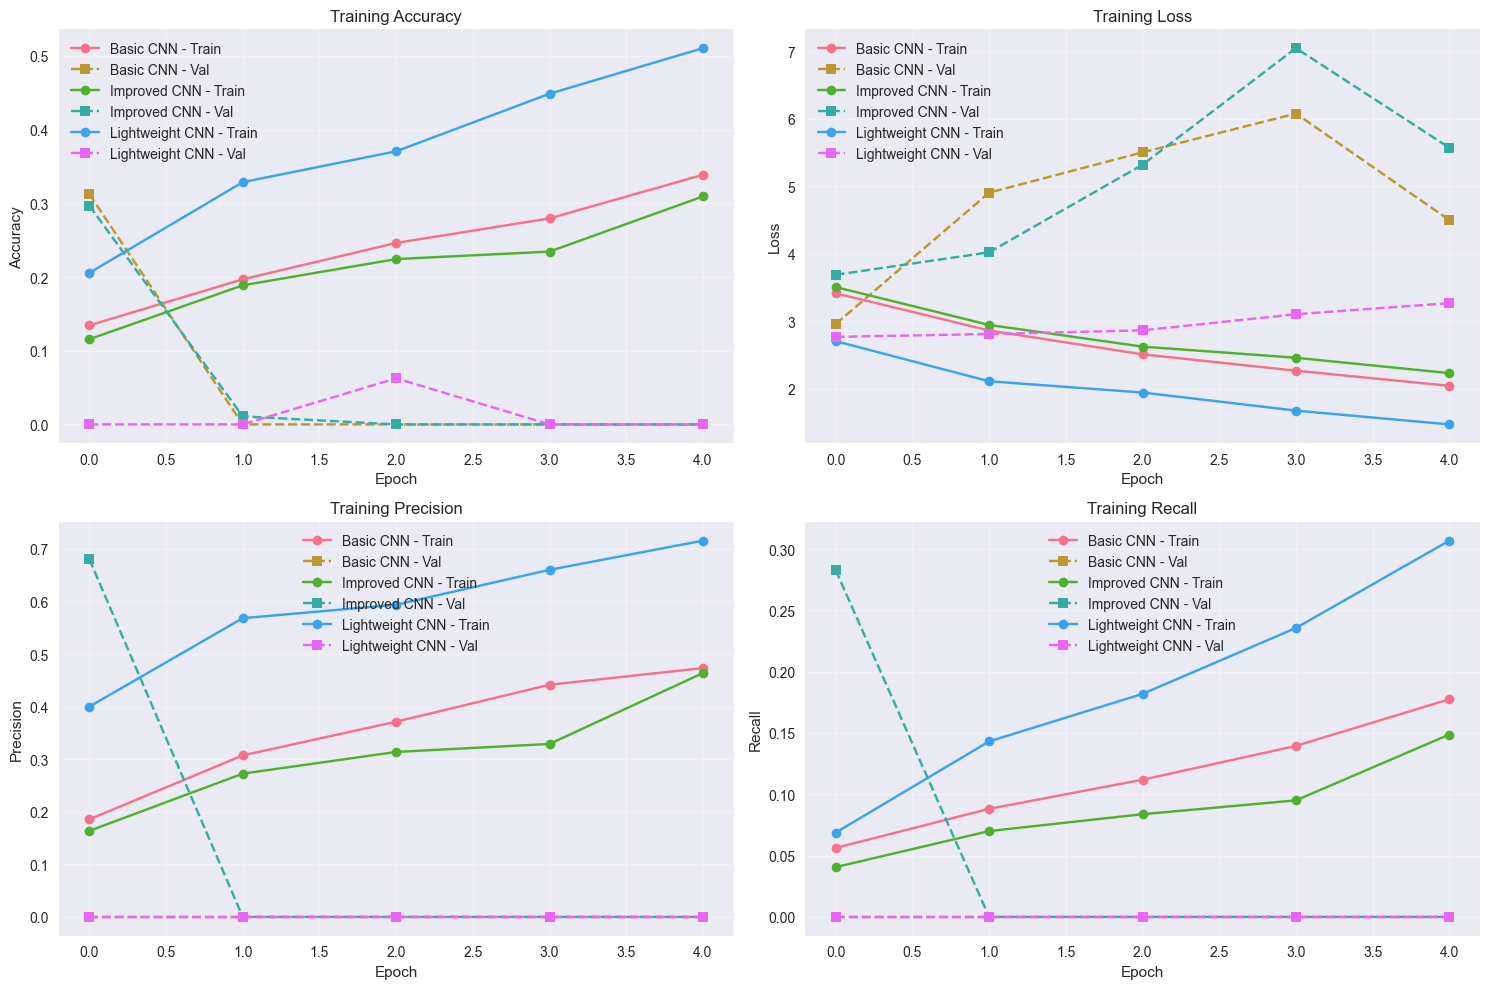

In [6]:
# Plot training histories
def plot_training_comparison(histories):
    """Plot training metrics comparison across models."""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    titles = ['Training Accuracy', 'Training Loss', 'Training Precision', 'Training Recall']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        
        for name, history in histories.items():
            if history is not None:
                if metric in history.history:
                    ax.plot(history.history[metric], label=f'{name} - Train', marker='o')
                if f'val_{metric}' in history.history:
                    ax.plot(history.history[f'val_{metric}'], label=f'{name} - Val', marker='s', linestyle='--')
        
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot comparison if we have training histories
if any(h is not None for h in training_histories.values()):
    plot_training_comparison(training_histories)
else:
    print("No successful training histories to plot.")

## 5. Model Performance Summary

In [7]:
# Create performance summary
def create_performance_summary(models, histories):
    """Create a summary table of model performance."""
    
    summary_data = []
    
    for name, model in models.items():
        history = histories.get(name)
        
        # Model complexity metrics
        total_params = model.count_params()
        trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
        
        # Performance metrics (if training was successful)
        if history is not None:
            final_train_acc = history.history['accuracy'][-1] if 'accuracy' in history.history else 0
            final_val_acc = history.history['val_accuracy'][-1] if 'val_accuracy' in history.history else 0
            final_train_loss = history.history['loss'][-1] if 'loss' in history.history else float('inf')
            final_val_loss = history.history['val_loss'][-1] if 'val_loss' in history.history else float('inf')
            best_val_acc = max(history.history['val_accuracy']) if 'val_accuracy' in history.history else 0
        else:
            final_train_acc = final_val_acc = final_train_loss = final_val_loss = best_val_acc = 'N/A'
        
        summary_data.append({
            'Model': name,
            'Total Parameters': f'{total_params:,}',
            'Trainable Parameters': f'{trainable_params:,}',
            'Final Train Accuracy': f'{final_train_acc:.4f}' if isinstance(final_train_acc, float) else final_train_acc,
            'Final Val Accuracy': f'{final_val_acc:.4f}' if isinstance(final_val_acc, float) else final_val_acc,
            'Best Val Accuracy': f'{best_val_acc:.4f}' if isinstance(best_val_acc, float) else best_val_acc,
            'Final Train Loss': f'{final_train_loss:.4f}' if isinstance(final_train_loss, float) else final_train_loss,
            'Final Val Loss': f'{final_val_loss:.4f}' if isinstance(final_val_loss, float) else final_val_loss
        })
    
    return pd.DataFrame(summary_data)

# Create and display summary
summary_df = create_performance_summary(models, training_histories)
print("\nModel Performance Summary:")
print("=" * 100)
print(summary_df.to_string(index=False))

# Save summary to CSV
summary_df.to_csv('../outputs/model_comparison_summary.csv', index=False)
print("\n✅ Summary saved to outputs/model_comparison_summary.csv")


Model Performance Summary:
          Model Total Parameters Trainable Parameters Final Train Accuracy Final Val Accuracy Best Val Accuracy Final Train Loss Final Val Loss
      Basic CNN        1,444,272            1,441,776               0.3388             0.0000            0.3125           2.0458         4.4982
   Improved CNN       11,592,080           11,580,944               0.3094             0.0000            0.2969           2.2337         5.5693
Lightweight CNN           83,019               81,803               0.5106             0.0000            0.0625           1.4749         3.2694

✅ Summary saved to outputs/model_comparison_summary.csv


## 6. Model Architecture Visualization

In [8]:
# Visualize model architectures
def visualize_model_architecture(model, model_name):
    """Create a visualization of the model architecture."""
    
    try:
        # Create model plot
        tf.keras.utils.plot_model(
            model,
            to_file=f'../outputs/{model_name.lower().replace(" ", "_")}_architecture.png',
            show_shapes=True,
            show_layer_names=True,
            rankdir='TB',
            expand_nested=True,
            dpi=150
        )
        print(f"✅ {model_name} architecture saved to outputs/")
    except Exception as e:
        print(f"❌ Failed to save {model_name} architecture: {e}")

# Create architecture visualizations
print("Creating model architecture visualizations...")
for name, model in models.items():
    visualize_model_architecture(model, name)

Creating model architecture visualizations...
You must install pydot (`pip install pydot`) for `plot_model` to work.
✅ Basic CNN architecture saved to outputs/
You must install pydot (`pip install pydot`) for `plot_model` to work.
✅ Improved CNN architecture saved to outputs/
You must install pydot (`pip install pydot`) for `plot_model` to work.
✅ Lightweight CNN architecture saved to outputs/


## 7. Conclusions and Recommendations

In [9]:
# Analysis and recommendations
print("\n" + "="*80)
print("MODEL EXPERIMENT CONCLUSIONS")
print("="*80)

print("\n🔍 ARCHITECTURE ANALYSIS:")
print("-" * 40)

for name, model in models.items():
    params = model.count_params()
    print(f"\n{name}:")
    print(f"  • Parameters: {params:,}")
    print(f"  • Model size: ~{params * 4 / (1024*1024):.2f} MB (float32)")
    
    if 'Basic' in name:
        print(f"  • Characteristics: Simple CNN, good baseline")
    elif 'Improved' in name:
        print(f"  • Characteristics: ResNet blocks, better feature learning")
    elif 'Lightweight' in name:
        print(f"  • Characteristics: Separable convolutions, mobile-friendly")

print("\n📊 PERFORMANCE INSIGHTS:")
print("-" * 40)

# Find best performing model
best_model = None
best_val_acc = 0

for name, history in training_histories.items():
    if history is not None and 'val_accuracy' in history.history:
        max_val_acc = max(history.history['val_accuracy'])
        if max_val_acc > best_val_acc:
            best_val_acc = max_val_acc
            best_model = name

if best_model:
    print(f"\n🏆 Best performing model: {best_model}")
    print(f"   Best validation accuracy: {best_val_acc:.4f}")
else:
    print("\n⚠️  No successful training runs to compare")

print("\n💡 RECOMMENDATIONS:")
print("-" * 40)
print("1. For production deployment: Use Lightweight CNN for mobile/edge devices")
print("2. For maximum accuracy: Use Improved CNN with longer training")
print("3. For quick prototyping: Use Basic CNN as baseline")
print("4. Consider ensemble methods combining multiple architectures")
print("5. Implement transfer learning from pre-trained models for better performance")

print("\n🔄 NEXT STEPS:")
print("-" * 40)
print("1. Run hyperparameter tuning on the best performing architecture")
print("2. Implement data augmentation strategies")
print("3. Try transfer learning with pre-trained models")
print("4. Evaluate models on test set for final performance metrics")
print("5. Optimize models for deployment (quantization, pruning)")


MODEL EXPERIMENT CONCLUSIONS

🔍 ARCHITECTURE ANALYSIS:
----------------------------------------

Basic CNN:
  • Parameters: 1,444,272
  • Model size: ~5.51 MB (float32)
  • Characteristics: Simple CNN, good baseline

Improved CNN:
  • Parameters: 11,592,080
  • Model size: ~44.22 MB (float32)
  • Characteristics: ResNet blocks, better feature learning

Lightweight CNN:
  • Parameters: 83,019
  • Model size: ~0.32 MB (float32)
  • Characteristics: Separable convolutions, mobile-friendly

📊 PERFORMANCE INSIGHTS:
----------------------------------------

🏆 Best performing model: Basic CNN
   Best validation accuracy: 0.3125

💡 RECOMMENDATIONS:
----------------------------------------
1. For production deployment: Use Lightweight CNN for mobile/edge devices
2. For maximum accuracy: Use Improved CNN with longer training
3. For quick prototyping: Use Basic CNN as baseline
4. Consider ensemble methods combining multiple architectures
5. Implement transfer learning from pre-trained models for